# K Means, Hierarchical Clustering, GMM Model, PCA Implementation 

## Import Packages

In [67]:
import numpy as np
import pandas as pd
import ssl
import math
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().magic(u'matplotlib inline')
import heapq
import itertools
import random
import copy
from pprint import pprint
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import scipy.cluster.hierarchy as hierarchy
from scipy.linalg import svd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

## Data Preprocessing

In [68]:
def data_preprocessing():
    
    
    df = pd.read_csv("intrusion_detection.csv")
    df["xAttack"] = df.apply(convert_string_to_float, axis=1)

    X = df.values[:, :-1] 
    y = df.values[:, -1]

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3,random_state = 0) 

    X_train = feature_scaling(X_train)
    
    return X_train, X_validation, y_train, y_validation
    

## Feature Scaling or Mean Normalisation 

In [70]:
def feature_scaling(train_data):
    
    no_of_columns = train_data.shape[1]
    
    global sd_mean_list
    
    sd_mean_list = []
    
    for index in range(no_of_columns):

        sd_val = np.std(train_data[:,index])
        mean_val = np.mean(train_data[:,index])
        train_data[:,index] = (train_data[:,index] - mean_val)/(sd_val)
        
        sd_mean_list.append([sd_val,mean_val])
        
    return train_data

## Standardization of test data

In [71]:
def scale_test_data(X_test):
    
    global sd_mean_list
    
    for test_row in X_test:
        
        for index in range(len(test_row)):

            mean = sd_mean_list[index][1]
            sd = sd_mean_list[index][0]

            test_row[index] = (test_row[index] - mean)/sd

    return X_test
    

## Convert string type label column to float

In [72]:
def convert_string_to_float(test_row):
    
    if test_row[-1] == "normal":
        return 0
    elif test_row[-1] == "dos":
        return  1
    elif test_row[-1] == "u2r":
        return  2
    elif test_row[-1] == "r2l":
        return  3
    elif test_row[-1] == "probe":
        return  4

# PCA Implementation

In [73]:
def PCA(X_train,k):

    global U, S, V, Z
    
    covmat = np.dot(X_train.T,X_train)/(X_train.shape[0])

    U, S, V = svd(covmat)

    Z = np.dot(X_train,U[:,0:k])

    return U, S, V, Z

In [74]:
def PCA_Visualization():
    
    global U, S, V, Z
    
    tot = sum(S)
    var_exp = [(i / tot)*100 for i in sorted(S, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    
    x_data = [i+1 for i in range(29)]
    x_datax = [i for i in range(29)]
    

    barplot = pd.DataFrame(
        {'Principal Components': x_data,
         'Variance': var_exp
        })

    barplot = barplot.melt('Principal Components',value_name='Variance')
    barplot_graph = sns.barplot(x="Principal Components", y="Variance", data=barplot)

    lineplot = pd.DataFrame(
        {'Principal Components': x_datax,
         'Variance': cum_var_exp
        })

    lineplot = lineplot.melt('Principal Components',value_name='Variance')
    lineplot_graph = sns.lineplot(x="Principal Components", y="Variance", data=lineplot)

## Applying PCA on test data

In [75]:
def PCA_test_data(X_validation,U,k):
    
    Z = np.dot(X_validation,U[:,0:k])
    
    return Z

# K Means Clustering Algorithm Implementation

In [76]:
class K_Means():

    def __init__(self, k = 5, error_tolerance = 0.0000000001, max_iterations = 100):
        self.k = k
        self.error_tolerance = error_tolerance
        self.max_iterations = max_iterations
        
    def euclidean_distance(self,data_row, centroid, axis = 1):
        return np.linalg.norm(data_row - centroid, axis = axis)
    
    def initialize_centroids(self,data):
        self.centroids = []
        
        for index in range(self.k):
            data_index = random.randint(0,data.shape[0])
            self.centroids.append(data[data_index,:])
            
        self.centroids = np.asarray(self.centroids) 

    def find_centroid_label(self,X_data,y):
        
        centroid_label_dict = {}
        
        self.cluster_purity = {}
        
        data_index = 0
        
        for row in X_data:
            
            distances = self.euclidean_distance(row,self.centroids)
            closest_cluster_index = np.argmin(distances)
            if closest_cluster_index not in centroid_label_dict:
                centroid_label_dict[closest_cluster_index] = []
            centroid_label_dict[closest_cluster_index].append(y[data_index])
        
            data_index += 1
        
        for key,values in centroid_label_dict.items():
            
            value,counts = np.unique(np.asarray(values), return_counts = True)
            centroid_label_occurence = -np.sort(-counts)[0]
            self.cluster_purity[key] = centroid_label_occurence/np.sum(counts)
            
            centroid_label_dict[key] = copy.deepcopy(max(set(values),key=values.count))
        
        return centroid_label_dict
        
    def fit(self,X_data,y):
        self.initialize_centroids(X_data)
        
        cluster = np.zeros(X_data.shape[0])
        
        old_centriod = np.zeros(self.centroids.shape)
        
        error = self.euclidean_distance(self.centroids, old_centriod, None)
        
        inter = 0
        while inter<self.max_iterations or error > self.error_tolerance:
            inter += 1
            
            index = 0
            for row in X_data:
                distances = self.euclidean_distance(row,self.centroids)
                
    
                closest_cluster_index = np.argmin(distances)
                cluster[index] = closest_cluster_index
                index += 1
        
  
            old_centriod = copy.deepcopy(self.centroids)

            for i in range(self.k):
          
                data_points = [X_data[j] for j in range(len(X_data)) if cluster[j] == i]
                if data_points:
         
                    self.centroids[i] = copy.deepcopy(np.mean(data_points, axis=0))
                del data_points
            
            error = self.euclidean_distance(old_centriod, self.centroids,1)
            error = np.sum(error)
            
        self.centroid_label_dict = self.find_centroid_label(X_data,y)
    
    def predict(self,X_data):
        
        y_predicted = np.zeros(X_data.shape[0])
        
        index = 0
        for row in X_data:

            distances = self.euclidean_distance(row,self.centroids)

            closest_cluster_index = np.argmin(distances)
            y_predicted[index] = self.centroid_label_dict[closest_cluster_index]
            index += 1
        
        return y_predicted
    

## Confusion Matrix Generation

In [77]:
def generate_confusion_matrix(y_actual,y_predicted):
    
    confusion_matrix = metrics.cluster.contingency_matrix(y_actual, y_predicted)
    
    return confusion_matrix 

## Accuracy Computation

In [78]:
def calculate_accuracy(y_actual,y_predicted):
    
    confusion_matrix = generate_confusion_matrix(y_actual,y_predicted)
    
    return np.sum(np.amax(confusion_matrix, axis=0))/np.sum(confusion_matrix)

## Train and Evaluate K Means Model

In [79]:
def kmeans_train_evaluate(no_of_principal_components,no_of_clusters):
    
    X_train, X_validation, y_train, y_validation = data_preprocessing()

    U, S, V, X = PCA(X_train,no_of_principal_components)
    
    scale_test_data(X_validation)
    X_validation = PCA_test_data(X_validation,U,no_of_principal_components)

    
    print("Custom Implementation of K Means Clustering")
    
    kmeans = K_Means(k = no_of_clusters)
    kmeans.fit(X,y_train)

    print()
    for key,values in kmeans.cluster_purity.items():
        print("Purity of cluster",key, " is: ", values)
    print()
    
    print("Performance on train data")
    y_predicted = kmeans.predict(X)
    print("Accuracy: ",calculate_accuracy(y_train,y_predicted))
    print()
    
    print("Clustering based on first two principal component using custom implementation")
    
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    
    plt.title('K Means clustering on training data based on Custom implementation')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.scatter(X[:, 0], X[:, 1], c=y_predicted, s=40, cmap='viridis');
    print("Performance on validation data")
    y_predicted = kmeans.predict(X_validation)
    print("Accuracy: ",calculate_accuracy(y_validation,y_predicted))
    
    print()
    
    print("Scikit Learn Library Implementation of K Means Clustering")

    plt.subplot(2, 1, 2)
    
    k_means = KMeans(n_clusters=5, random_state=0)
    
    k_means.fit(X)
        
    print("Performance on train data")
    y_pred_train = k_means.predict(X)
    print("Accuracy: ",calculate_accuracy(y_train,y_pred_train))
    print()
    print("Clustering based on first two principal component using Scikit Learn")
    
    plt.title('K Means clustering on training data based on Scikit Learn library')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.scatter(X[:, 0], X[:, 1], c=y_pred_train, s=40, cmap='viridis');
    
    print("Performance on validation data")
    y_pred_validation = k_means.predict(X_validation)
    print("Accuracy: ",calculate_accuracy(y_validation,y_pred_validation))


## Hierarchical Clustering

In [80]:
def hierarchial_clustering(linkage_type,no_of_principal_components, no_of_clusters):
    

    X_train, X_validation, y_train, y_validation = data_preprocessing()
    U, S, V, X = PCA(X_train,no_of_principal_components)

    X_validation = scale_test_data(X_validation)
    X_validation = PCA_test_data(X_validation,U,no_of_principal_components)
    
    
    Y = pdist(X)
    Z = hierarchy.linkage(Y, method = linkage_type, metric = "euclidean")
    T = hierarchy.fcluster(Z, no_of_clusters, criterion = "maxclust")
    
    lens = {}      
    centroids = {} 
    for idx,clno in enumerate(T):
        centroids.setdefault(clno,np.zeros(5)) 
        centroids[clno] += X[idx,:]
        lens.setdefault(clno,0)
        lens[clno] += 1
    
    for clno in centroids:
        centroids[clno] /= float(lens[clno])
        
    centroid_positions = []

    
    for key ,values in centroids.items():
        centroid_positions.append(values.tolist())
    
    centroid_positions = np.asarray(centroid_positions)
    
    centroids_labels_dicts = {}
    
    index = 0
    for row in X:
        
        distances = np.linalg.norm(row - centroid_positions, axis = 1)
        
        closest_cluster_index = np.argmin(distances)
        
        if closest_cluster_index not in centroids_labels_dicts:
            centroids_labels_dicts[closest_cluster_index] = []

        centroids_labels_dicts[closest_cluster_index].append(y_train[index])
        
        index += 1
        
    
    print()
    for key,values in centroids_labels_dicts.items():
    
        value,counts = np.unique(np.asarray(values), return_counts = True)

        centroid_label_occurence = -np.sort(-counts)[0]
        purity = centroid_label_occurence/np.sum(counts)
        
        print("Purity of cluster",key, " is: ", purity)
        
    print()
    
    Z = linkage(X, linkage_type)

    plt.figure(figsize=(10, 20))
    plt.subplot(3, 1, 1)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        truncate_mode='lastp', 
        p=no_of_clusters,  
        show_leaf_counts=True,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
    )
    
    
    clustering_model = AgglomerativeClustering(affinity='euclidean',linkage=linkage_type,n_clusters=no_of_clusters)
    clustering_model.fit(X)
    
    plt.subplot(3, 1, 2)  
    plt.title('Hierarchical clustering on training data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X[:,0], X[:,1], c=clustering_model.labels_, cmap='viridis')  

    y_train_predicted = clustering_model.fit_predict(X)
    y_validation_predicted = clustering_model.fit_predict(X_validation)

    plt.subplot(3, 1, 3)
    plt.title('Hierarchical clustering on validation data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X_validation[:,0], X_validation[:,1], c=y_validation_predicted, cmap='viridis')
    
    plt.show()

    print("Accuracy on train data: ",calculate_accuracy(y_train_predicted,y_train))

    print("Accuracy on validation data: ",calculate_accuracy(y_validation_predicted,y_validation))

In [81]:
def train_evaluation_hierarical_model(linkage_type,no_of_principal_components, no_of_clusters):
    
    print()
    print("Using linkage type ",linkage_type)
    hierarchial_clustering(linkage_type,no_of_principal_components, no_of_clusters)
    print()

In [96]:
def visualize_pie_chart(no_of_principal_components, no_of_clusters):
    
    X_train, X_validation, y_train, y_validation = data_preprocessing()
    U, S, V, X = PCA(X_train,no_of_principal_components)

    X_validation = scale_test_data(X_validation)
    X_validation = PCA_test_data(X_validation,U,no_of_principal_components)
    
    linkage_list = ['ward','single','average','complete']
    
    train_accuracy_list = []
    validation_accuracy_list = []
    
    for linkage_type in linkage_list:
    
        clustering_model = AgglomerativeClustering(affinity='euclidean',linkage=linkage_type,n_clusters=no_of_clusters)
        clustering_model.fit(X)

        y_train_predicted = clustering_model.fit_predict(X)
        y_validation_predicted = clustering_model.fit_predict(X_validation)
        
        train_accuracy_list.append(calculate_accuracy(y_train_predicted,y_train))
        validation_accuracy_list.append(calculate_accuracy(y_validation_predicted,y_validation))
        
    
    train_df = pd.DataFrame({
        
        "Linkage_Type":linkage_list,
        "Accuracy":train_accuracy_list
    })
    
    validation_df = pd.DataFrame({
        
        "Linkage_Type":linkage_list,
        "Accuracy":validation_accuracy_list
    })
    
    print(train_df)
    print(validation_df)
    
    train_accuracy = train_df.Accuracy.groupby(train_df.Linkage_Type).sum()
    plt.axis('equal');
    plt.pie(train_accuracy, labels=train_accuracy.index);
    plt.show()
    
    validation_accuracy = validation_df.Accuracy.groupby(validation_df.Linkage_Type).sum()
    plt.axis('equal');
    plt.pie(validation_accuracy, labels=validation_accuracy.index);
    plt.show()

  Linkage_Type  Accuracy
0         ward  0.787461
1       single  0.999486
2      average  0.999486
3     complete  0.996742
  Linkage_Type  Accuracy
0         ward  0.838533
1       single  0.999467
2      average  0.999467
3     complete  0.999467


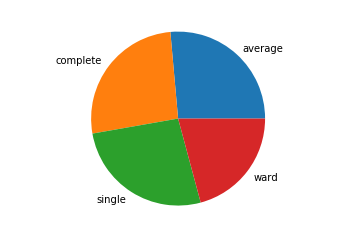

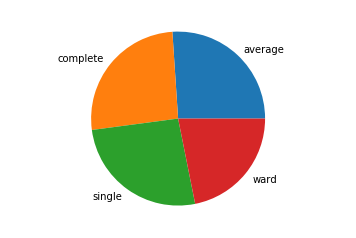

In [97]:
no_of_principal_components = 5
no_of_clusters = 5
visualize_pie_chart(no_of_principal_components, no_of_clusters)

# Gaussian Mixture Model 

In [82]:
def gausian_mixture_model(no_of_principal_components, no_of_clusters):

    global sd_mean_list
    
    X_train, X_validation, y_train, y_validation = data_preprocessing()

    U, S, V, X = PCA(X_train,no_of_principal_components)
    
    gmm = GaussianMixture(n_components=no_of_clusters).fit(X)
    y_train_predicted = gmm.predict(X)
    
    X_validation = scale_test_data(X_validation)
    X_validation = PCA_test_data(X_validation,U,no_of_principal_components)
    
    centroids_labels_dicts = {}
    
    index = 0
    for row in X:
        
        distances = np.linalg.norm(row - gmm.means_, axis = 1)
        
        closest_cluster_index = np.argmin(distances)
        
        if closest_cluster_index not in centroids_labels_dicts:
            centroids_labels_dicts[closest_cluster_index] = []
                
        centroids_labels_dicts[closest_cluster_index].append(y_train[index])
        
        index += 1
        
    
    print()
    for key,values in centroids_labels_dicts.items():
    
        value,counts = np.unique(np.asarray(values), return_counts = True)
        centroid_label_occurence = -np.sort(-counts)[0]
        purity = centroid_label_occurence/np.sum(counts)
        
        print("Purity of cluster",key, " is: ", purity)
        print()
    print()
    
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    
    plt.title('GMM clustering on train data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X[:,0], X[:,1], c = y_train_predicted, s=40, cmap='viridis')
     
    y_validation_predicted = gmm.predict(X_validation)
    
    print()
    print()
    
    plt.subplot(2, 1, 2)
    
    plt.title('GMM clustering on train data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X_validation[:,0], X_validation[:,1], c = y_validation_predicted, s=40, cmap='viridis')
        
    print("Accuracy on train dataset: ",calculate_accuracy(y_train, y_train_predicted))
    print("Accuracy on validation dataset: ",calculate_accuracy(y_validation, y_validation_predicted))

## Q - 1 - 2

Custom Implementation of K Means Clustering

Purity of cluster 3  is:  0.8934904844290658
Purity of cluster 4  is:  0.9905921416712784
Purity of cluster 1  is:  0.9761273209549072
Purity of cluster 2  is:  0.45485272815065186
Purity of cluster 0  is:  0.5302359882005899

Performance on train data
Accuracy:  0.8376957366556178

Clustering based on first two principal component using custom implementation
Performance on validation data
Accuracy:  0.8413333333333334

Scikit Learn Library Implementation of K Means Clustering
Performance on train data
Accuracy:  0.8372385415476055

Clustering based on first two principal component using Scikit Learn
Performance on validation data
Accuracy:  0.8409333333333333


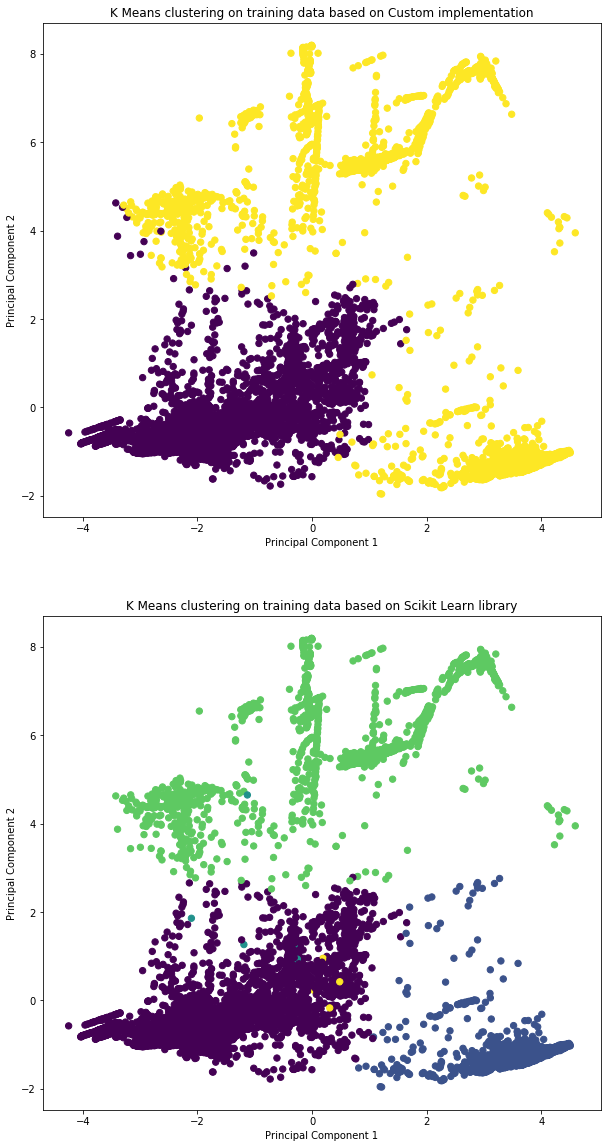

In [83]:
no_of_principal_components = 17
no_of_clusters = 5
kmeans_train_evaluate(no_of_principal_components,no_of_clusters)

## Q - 1 - 1

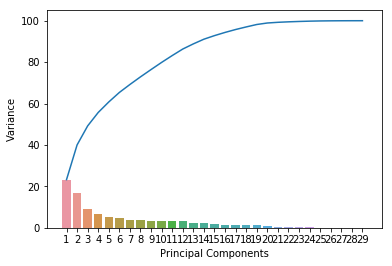

In [84]:
PCA_Visualization()

## Q - 1 - 3


Purity of cluster 4  is:  0.9019173223983155

Purity of cluster 0  is:  0.9811203319502074

Purity of cluster 2  is:  0.48936170212765956

Purity of cluster 1  is:  0.4945652173913043

Purity of cluster 3  is:  0.53125




Accuracy on train dataset:  0.8179220482340839
Accuracy on validation dataset:  0.8212


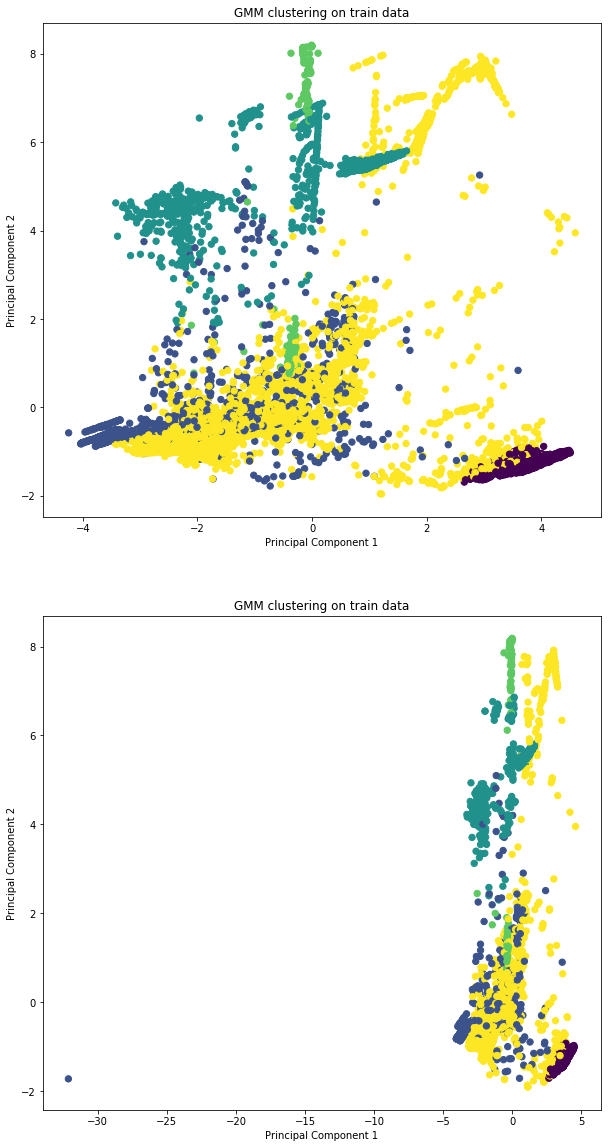

In [85]:
no_of_principal_components = 17
no_of_clusters = 5
gausian_mixture_model(no_of_principal_components,no_of_clusters)

## Q - 1 - 4


Using linkage type  ward

Purity of cluster 0  is:  0.8649230438058336
Purity of cluster 1  is:  0.9825508932280848
Purity of cluster 2  is:  0.4491927825261159
Purity of cluster 3  is:  0.7324492979719188
Purity of cluster 4  is:  1.0



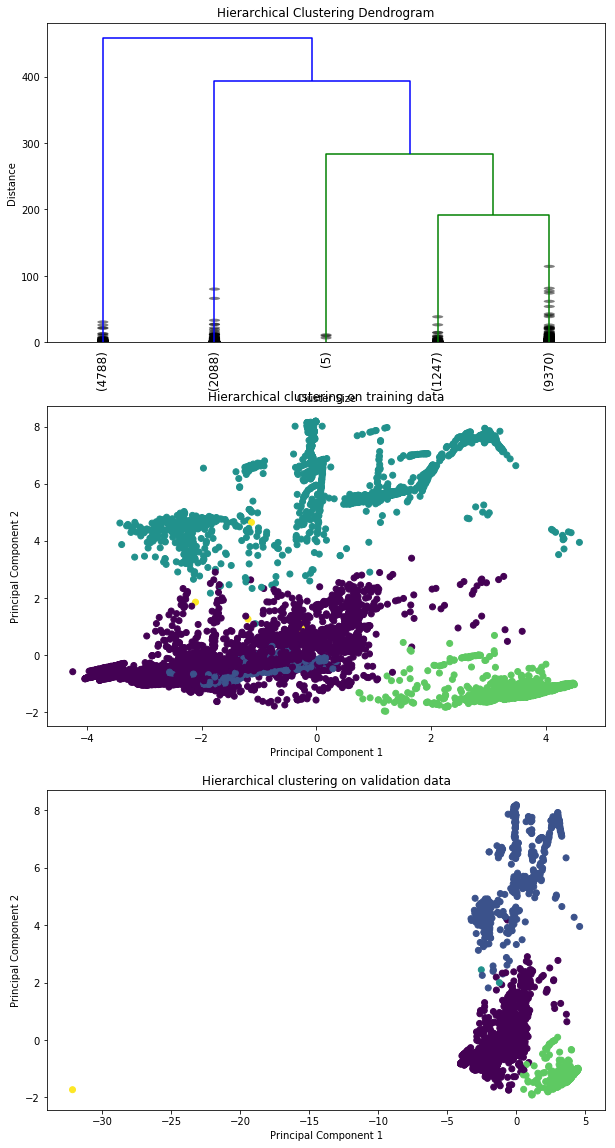

Accuracy on train data:  0.7874614241627614
Accuracy on validation data:  0.8385333333333334



In [86]:
no_of_principal_components = 5
no_of_clusters = 5
linkage_type = "ward" #single, complete, average
train_evaluation_hierarical_model(linkage_type,no_of_principal_components, no_of_clusters)

visualize_pie_chart(no_of_principal_components,no_of_clusters)

## Q - 1 - 5

PCA can be applied on categorical data (preprocessing categorical data such a way that numerical computations are possible) and it will give some result but it might not be very meaningful as in PCA we try to minimize variance which in case of categorical data does not make sense. PCA is designed for continuous variable but mathematically there is nothing stopping us to apply PCA on categorical data. One of the biggest challenge for applying PCA on categorical data is we need to have a distance measure which can tell us distance between two distinct categorical values.For dataset containing categorical features Multiple Correspondence Analysis is a better approach.  